In [1]:
from packaging import version
import tensorflow as tf
import sys
assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [2]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install gymnasium[atari]==0.29.1
    %pip install gymnasium[classic_control,box2d,accept-rom-license,ActionWrapper]==0.29.1
else:
    !pip install -q -U gymnasium swig
    !pip install gymnasium[atari]==0.29.1
    !pip install gymnasium[classic_control,box2d,accept-rom-license]==0.29.1

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0


In [3]:
# Verify installation
import gymnasium as gym
sorted(gym.envs.registry.keys())[:5] + ["..."]

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

In [4]:
# Constants
import numpy as np
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
env = gym.make('VideoPinballDeterministic-v4', render_mode="rgb_array")
obs = env.reset(seed=SEED)
obs

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {'lives': 3,
  'episode_frame_number': 0,
  'frame_number': 0,
  'seeds': (3444837047, 2669555309)})

In [6]:
img = env.render()
img.shape

C:\Users\bayan\miniconda3\envs\CS4278-assignment3\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


(210, 160, 3)

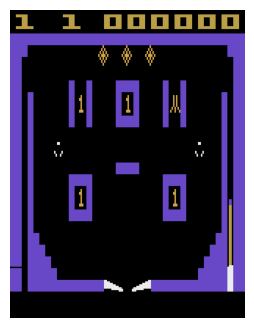

In [7]:
import matplotlib.pyplot as plt

def plot_environment(env, figsize=(5, 4)):
  plt.figure(figsize=figsize)
  img = env.render()
  plt.imshow(img)
  plt.axis("off")
  return img

plot_environment(env)
plt.show()

In [8]:
n_outputs = env.action_space.n
# input_shape = (np.prod(env.observation_space.shape),)
input_shape = env.observation_space.shape

print(n_outputs)
print(input_shape)

9
(210, 160, 3)


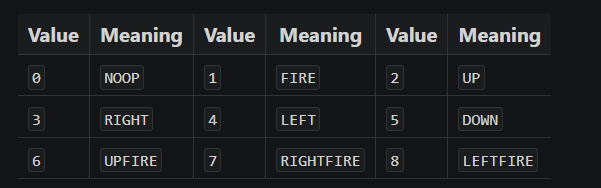

In [9]:
# Constants
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# We are using Pinball Deterministic
# This skips every fourth frame/tick
# We are using the pixels in the environment to learn as we believe it best mimics a human learning to play
env_string = 'VideoPinballDeterministic-v4'

class DQN():
  def __init__(self, 
               env_string,
               batch_size=64):
    self.memory = deque(maxlen=100000)
    self.env = gym.make(env_string)

    input_size = (84, 84, 1)
    action_size = self.env.action_space.n

    print(f'self.env.observation_space = {self.env.observation_space}')
    print(f'input_size = {input_size}')
    print(f'action_size = {action_size}')

    self.batch_size = batch_size
    self.gamma = 1.0
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    # This decay rate implies we will need ~920 episodes to reach epsilon_min as it reduces the epsilon by 0.005 per episode
    self.epsilon_decay = 0.995
    alpha=0.01
    # todo: what is this supposed to do?
    alpha_decay=0.01
    #if MONITOR: self.env = gym.wrappers.Monitor(self.env, '../data/'+env_string, force=True)
      
    self.build_model(input_size, action_size, alpha)
  
  def build_model(self, input_shape, n_actions, alpha):
    # Init model
    self.model = Sequential()
    self.model.add(Input(shape=input_shape))
    self.model.add(BatchNormalization())
    # Convolutional layers
    self.model.add(Conv2D(32, (8, 8), strides=4, activation='relu'))
    self.model.add(BatchNormalization())
    self.model.add(Conv2D(64, (4, 4), strides=2, activation='relu'))
    self.model.add(BatchNormalization())
    self.model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
    self.model.add(BatchNormalization())

    # Fully connected layers
    self.model.add(Flatten())
    self.model.add(Dense(512, activation='relu'))
    self.model.add(Dense(n_actions, activation='linear'))

    # Compile
    self.model.compile(loss = 'mse', optimizer=Adam(learning_rate = alpha))

  # Add the step to memory
  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  # Epsilon greedy strategy
  def choose_action(self, state, epsilon):
    # Randomly choose a random (exploratory) move based on epsilon
    # Epsilon is the chance of choosing an exploratory move
    if np.random.random() <= epsilon:
      return self.env.action_space.sample()
    # Otherwise choose an exploitative move
    # From our model's predictions we choose what it thinks is most likely to be the optimal move
    else:
      return np.argmax(self.model.predict(state, verbose=0))

  # Preprocessing the state to reduce computation as we are using the resolution of the game (210x160x3)
  def preprocess_state(self, state):
      if len(state) == 2:
        img = state[0]
      else:
        img = state
      # Trim out the top (score & lives) and bottom (black space) as it contains no useful information for our model
      img = img[22:192]
      # Reduce the number of channels from 3 to 1 as colour is unlikely to have a big effect on performance
      img = tf.image.rgb_to_grayscale(img)
      # Scaling down the image to a more manageable size
      # todo: does aspect ratio have an effect on learning?
      img = tf.image.resize([img], [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
      img = tf.cast(img, tf.float32)
      return img

  def replay(self, batch_size):
    if len(self.memory) < batch_size:
      return
    
    x_batch, y_batch = [], []
    minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
    for state, action, reward, next_state, done in minibatch:
      y_target = self.model.predict(state, verbose=0)
      y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state, verbose=0)[0])
      x_batch.append(state[0])
      y_batch.append(y_target[0])

    self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)

  def train(self, epochs = 100):
    scores = deque(maxlen=100)
    avg_scores = []
    
    for e in range(epochs):
      state = self.env.reset()
      state = self.preprocess_state(state)
      done = False
      # Score is no. of ticks survived
      score = 0
      while not done:
        action = self.choose_action(state, self.epsilon)
        next_state, reward, done, _, _ = self.env.step(action)
        next_state = self.preprocess_state(next_state)
        self.remember(state, action, reward, next_state, done)
        state = next_state
        score += 1
          
      scores.append(score)
      mean_score = np.mean(scores)
      avg_scores.append(mean_score)

      print(f'Episode {e+1}/{epochs} complete, score: {score}, epsilon: {np.round(self.epsilon, 4)}')
      if (e+1) % 20 == 0:
        print(f'[Episode {e+1}] - Mean survival time over last 20 episodes was {mean_score} ticks.')

      self.replay(self.batch_size)
      # Decrease epsilon after each episode to gradually shift from random to learned actions
      self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon)
    
    return avg_scores

agent = DQN(env_string)
agent.model.summary()

self.env.observation_space = Box(0, 255, (210, 160, 3), uint8)
input_size = (84, 84, 1)
action_size = 9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 84, 84, 1)         4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        2080      
                                                                 
 batch_normalization_1 (Bat  (None, 20, 20, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 batch_normalization_2 (Bat  (None, 9, 9, 64)          256       
 chNormalization) 

In [ ]:
scores = agent.train()

Episode 1/100 complete, score: 2081, epsilon: 1.0
Episode 2/100 complete, score: 3811, epsilon: 0.995
Episode 3/100 complete, score: 1684, epsilon: 0.990025
Episode 4/100 complete, score: 3341, epsilon: 0.985074875
Episode 5/100 complete, score: 2078, epsilon: 0.9801495006250001
Episode 6/100 complete, score: 2179, epsilon: 0.9752487531218751
Episode 7/100 complete, score: 2371, epsilon: 0.9703725093562657
Episode 8/100 complete, score: 3441, epsilon: 0.9655206468094844
Episode 9/100 complete, score: 3150, epsilon: 0.960693043575437
Episode 10/100 complete, score: 1468, epsilon: 0.9558895783575597
Episode 11/100 complete, score: 3416, epsilon: 0.9511101304657719
Episode 12/100 complete, score: 2367, epsilon: 0.946354579813443
Episode 13/100 complete, score: 3810, epsilon: 0.9416228069143757
Episode 14/100 complete, score: 2074, epsilon: 0.9369146928798039
Episode 15/100 complete, score: 1462, epsilon: 0.9322301194154049
Episode 16/100 complete, score: 2926, epsilon: 0.9275689688183278


In [ ]:
plt.plot(scores)
plt.show()